In [18]:
%pip install pandas sodapy matplotlib seaborn plotly

In [19]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from google.cloud import storage
import re


In [20]:

# --- Configurações da API Socrata ---
socrata_domain = "data.wa.gov"
socrata_dataset_id = "f6w7-q2d2"
limit = 50000 # Aumentei o limite, mas lembre-se que pode haver paginação para mais dados.

print("Conectando à API Socrata...")
# Cliente não autenticado (para datasets públicos).
# Se precisar de autenticação, use:
# client = Socrata(socrata_domain, "YOUR_APP_TOKEN", username="user@example.com", password="AFakePassword")
# Para um token de aplicativo, você precisaria criar um no Socrata e armazená-lo com segurança
# (ex: Secret Manager se fosse em produção, mas para notebook pode ser direto se for público ou teste).
client = Socrata(socrata_domain, None)

# --- Coleta de Dados da API ---
try:
    # A Socrata API pode ter limites de 1000, 2000 ou 50000. Use loops para paginação se precisar de tudo.
    # Exemplo simples para um limite:
    results = client.get(socrata_dataset_id, limit=limit)
    print(f"Coletados {len(results)} registros da API.")

    if not results:
        print("Nenhum dado retornado da API Socrata. Verifique o ID do dataset ou limites.")
        # Pode querer parar a execução ou retornar aqui
        # return

    df = pd.DataFrame.from_records(results)

    print("Nomes das colunas ANTES da limpeza:")
    print(df.columns.tolist())

    # --- Nova Seção: Limpar Nomes de Colunas ---
    print("\nLimpando nomes de colunas para compatibilidade com BigQuery...")

    # Função para sanitizar um nome de coluna
    def sanitize_column_name(col_name):
        # 1. Substituir caracteres especiais (não alfanuméricos e não sublinhados) por sublinhados
        # Mantém letras (a-z, A-Z), números (0-9) e sublinhados (_)
        # e substitui o resto por um sublinhado.
        col_name = re.sub(r'[^a-zA-Z0-9_]', '_', col_name)

        # 2. Remover múltiplos sublinhados consecutivos (se houver)
        col_name = re.sub(r'_{2,}', '_', col_name)

        # 3. Remover sublinhados do início ou do fim
        col_name = col_name.strip('_')

        # 4. Converter para minúsculas (boa prática para o BigQuery)
        col_name = col_name.lower()

        # 5. Se o nome começar com um número, adicione um prefixo (ex: 'col_')
        if re.match(r'^[0-9]', col_name):
            col_name = 'col_' + col_name

        return col_name

    # Aplicar a função de sanitização a todos os nomes de colunas
    df.columns = [sanitize_column_name(col) for col in df.columns]

    print("Nomes das colunas DEPOIS da limpeza:")
    print(df.columns.tolist())

except Exception as e:
    print(f"Erro ao coletar dados da API Socrata: {e}")
    # Parar a execução ou tratar o erro conforme a necessidade
    raise # Relança o erro para o notebook exibir

print("\n--- Informações Iniciais do DataFrame ---")
print(df.head())
print("\n")
print(df.info())
print("\n")
print(df.columns)
print("\n")



Conectando à API Socrata...
Coletados 50000 registros da API.
Nomes das colunas ANTES da limpeza:
['vin_1_10', 'county', 'city', 'state', 'zip_code', 'model_year', 'make', 'model', 'ev_type', 'cafv_type', 'electric_range', 'base_msrp', 'legislative_district', 'dol_vehicle_id', 'geocoded_column', 'electric_utility', '_2020_census_tract', ':@computed_region_x4ys_rtnd', ':@computed_region_fny7_vc3j', ':@computed_region_8ddd_yn5v']

Limpando nomes de colunas para compatibilidade com BigQuery...
Nomes das colunas DEPOIS da limpeza:
['vin_1_10', 'county', 'city', 'state', 'zip_code', 'model_year', 'make', 'model', 'ev_type', 'cafv_type', 'electric_range', 'base_msrp', 'legislative_district', 'dol_vehicle_id', 'geocoded_column', 'electric_utility', 'col_2020_census_tract', 'computed_region_x4ys_rtnd', 'computed_region_fny7_vc3j', 'computed_region_8ddd_yn5v']

--- Informações Iniciais do DataFrame ---
     vin_1_10    county      city state zip_code model_year   make    model  \
0  5YJ3E1EB6K 

In [21]:
# --- Pré-processamento e Limpeza ---
# ATENÇÃO: Nomes das colunas da API Socrata são geralmente em snake_case.
# Adaptei as colunas abaixo. CONFIRA os nomes reais das colunas da API
# olhando o `df.columns` após a coleta.

# Renomear colunas para facilitar o uso (opcional, mas boa prática)
# Mapeamento para nomes mais legíveis, se necessário
column_mapping = {
    'make': 'Make',
    'electric_vehicle_type': 'Electric Vehicle Type',
    'electric_range': 'Electric Range',
    'model_year': 'Model Year',
    'base_msrp': 'Base MSRP',
    'model': 'Model',
    'state': 'State',
    'clean_alternative_fuel_vehicle_cafv_eligibility': 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'electric_utility': 'Electric Utility'
    # Adicione outros mapeamentos conforme necessário para as colunas que você usa
}
df = df.rename(columns=column_mapping)

# Converter tipos de dados. `errors='coerce'` converte valores inválidos para NaN.
print("Convertendo tipos de dados...")
for col in ['Electric Range', 'Base MSRP', 'Model Year']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remover linhas com valores NaN essenciais após a conversão
df.dropna(subset=['Electric Range', 'Base MSRP'], inplace=True)

print(f"\nDataFrame após pré-processamento: {df.shape[0]} linhas, {df.shape[1]} colunas.")
print(df.head())



Convertendo tipos de dados...

DataFrame após pré-processamento: 49998 linhas, 20 colunas.
     vin_1_10    county      city State zip_code  Model Year   Make    Model  \
0  5YJ3E1EB6K      King   Seattle    WA    98178        2019  TESLA  MODEL 3   
1  5YJYGAEE5M    Yakima     Selah    WA    98942        2021  TESLA  MODEL Y   
2  5YJSA1E65N    Yakima   Granger    WA    98932        2022  TESLA  MODEL S   
3  5YJ3E1EBXN      King  Bellevue    WA    98004        2022  TESLA  MODEL 3   
4  JM3KKEHA8S  Thurston      Yelm    WA    98597        2025  MAZDA    CX-90   

                                  ev_type  \
0          Battery Electric Vehicle (BEV)   
1          Battery Electric Vehicle (BEV)   
2          Battery Electric Vehicle (BEV)   
3          Battery Electric Vehicle (BEV)   
4  Plug-in Hybrid Electric Vehicle (PHEV)   

                                           cafv_type  Electric Range  \
0            Clean Alternative Fuel Vehicle Eligible           220.0   
1  Eligibilit


--- Gerando Visualizações ---


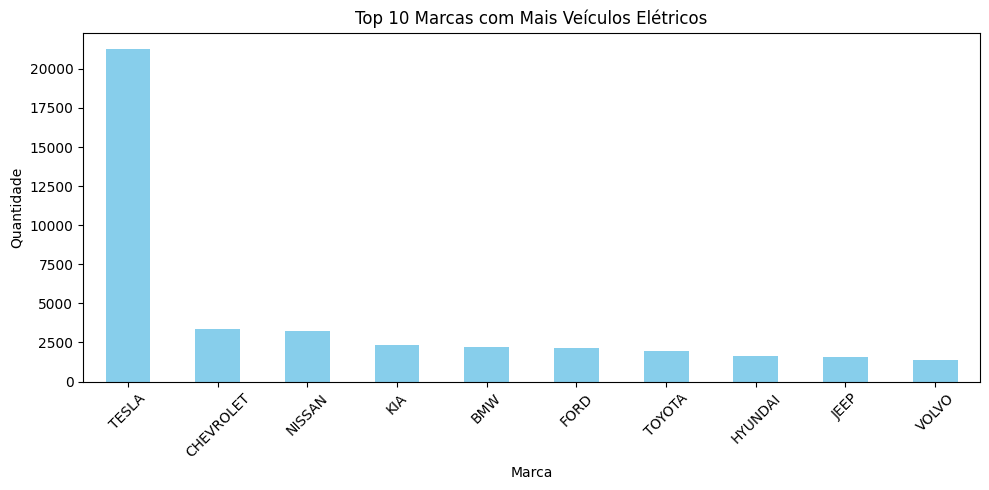

In [22]:
# --- Visualizações (diretamente no notebook) ---

print("\n--- Gerando Visualizações ---")

# Gráfico 1: Top 10 Marcas com Mais Veículos Elétricos
if 'Make' in df.columns:
    plt.figure(figsize=(10, 5))
    df['Make'].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title('Top 10 Marcas com Mais Veículos Elétricos')
    plt.xlabel('Marca')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'Make' não encontrada para o gráfico Top 10 Marcas.")


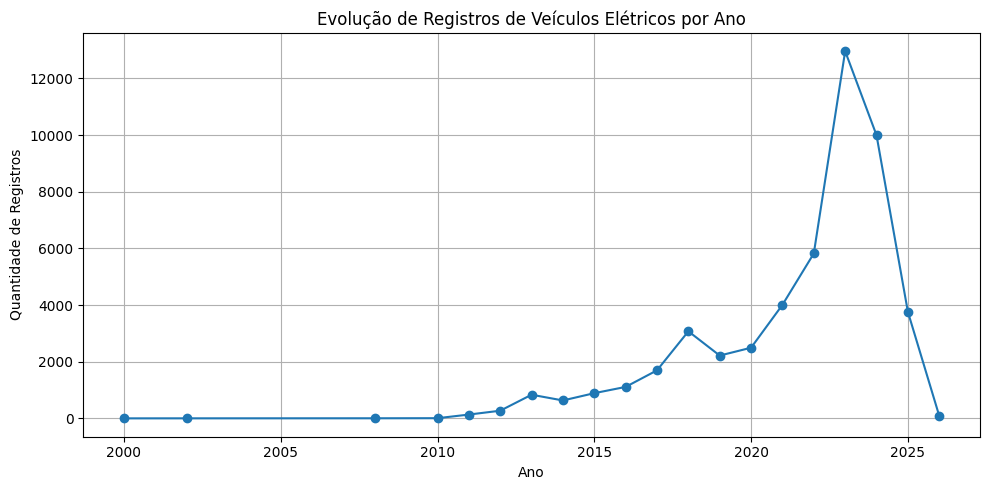

In [23]:
# Gráfico 3: Evolução de Registros de Veículos Elétricos por Ano
if 'Model Year' in df.columns:
    plt.figure(figsize=(10, 5))
    # Garante que 'Model Year' seja inteiro antes de value_counts para evitar problemas com floats (NaNs tratados acima)
    df['Model Year'] = df['Model Year'].astype(int, errors='ignore')
    df['Model Year'].value_counts().sort_index().plot(kind='line', marker='o')
    plt.title('Evolução de Registros de Veículos Elétricos por Ano')
    plt.xlabel('Ano')
    plt.ylabel('Quantidade de Registros')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'Model Year' não encontrada para o gráfico de evolução.")

In [24]:
# --- Transformações Adicionais e Análises ---

print("\n--- Realizando Transformações e Análises ---")

# Autonomia por Preço
if 'Electric Range' in df.columns and 'Base MSRP' in df.columns:
    df['Autonomia_por_Preco'] = df['Electric Range'] / df['Base MSRP']
    print("Coluna 'Autonomia_por_Preco' criada.")
else:
    print("Não foi possível criar 'Autonomia_por_Preco': colunas 'Electric Range' ou 'Base MSRP' ausentes.")





--- Realizando Transformações e Análises ---
Coluna 'Autonomia_por_Preco' criada.



Top 10 Modelos Mais Eficientes (Autonomia por Preço):
Model
330E           inf
SORENTO        inf
OUTLANDER      inf
PACIFICA       inf
PRIUS PHEV     inf
PRIUS PRIME    inf
PS2            inf
Q5 E           inf
RAV4 PRIME     inf
SOUL           inf
Name: Autonomia_por_Preco, dtype: float64


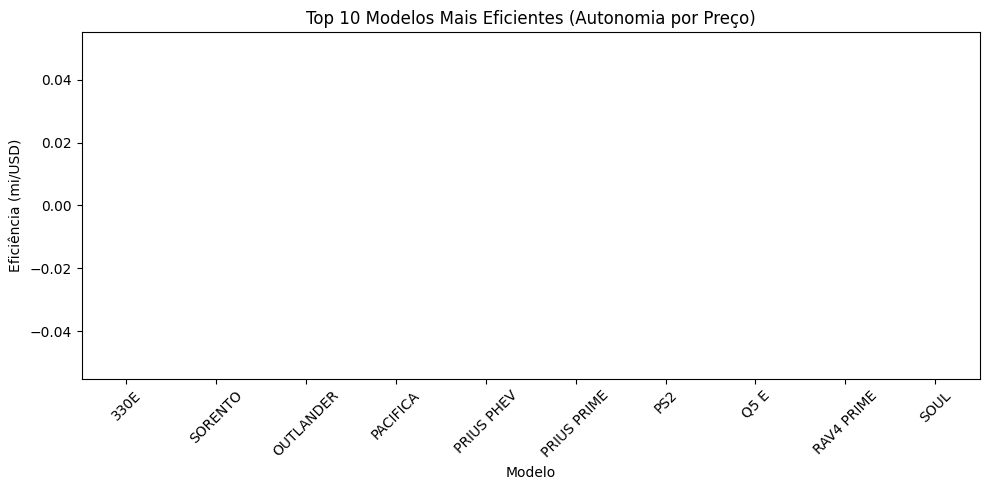

In [25]:
# Top 10 Modelos Mais Eficientes (Autonomia por Preço)
if 'Model' in df.columns and 'Autonomia_por_Preco' in df.columns:
    modelos_populares = df['Model'].value_counts()
    modelos_filtrados = modelos_populares[modelos_populares > 100].index
    df_filtrado = df[df['Model'].isin(modelos_filtrados)]

    if not df_filtrado.empty:
        eficiencia_modelo = df_filtrado.groupby('Model')['Autonomia_por_Preco'].mean().sort_values(ascending=False).head(10)
        print("\nTop 10 Modelos Mais Eficientes (Autonomia por Preço):")
        print(eficiencia_modelo)

        plt.figure(figsize=(10, 5))
        eficiencia_modelo.plot(kind='bar', color='orange')
        plt.title('Top 10 Modelos Mais Eficientes (Autonomia por Preço)')
        plt.xlabel('Modelo')
        plt.ylabel('Eficiência (mi/USD)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhum modelo popular suficiente para análise de eficiência.")
else:
    print("Colunas 'Model' ou 'Autonomia_por_Preco' ausentes para análise de eficiência.")




In [26]:
# Top Autonomia Modelos
if 'Model' in df.columns and 'Electric Range' in df.columns:
    top_autonomia = df[['Model', 'Electric Range']].groupby('Model').mean().sort_values(by='Electric Range', ascending=False).head(10)
    print("\nTop Autonomia Modelos:")
    print(top_autonomia)
else:
    print("Colunas 'Model' ou 'Electric Range' ausentes para Top Autonomia Modelos.")





Top Autonomia Modelos:
          Electric Range
Model                   
ROADSTER      237.307692
MODEL S       168.789864
MACAN         167.404255
I-PACE        165.927273
BOLT EV       161.434290
E-TRON        135.069124
MODEL X       121.218009
E-GOLF        108.601594
RAV4          101.769231
CITY          100.000000


In [27]:
# Contagem por Estado
if 'State' in df.columns:
    estado_contagem = df['State'].value_counts().reset_index()
    estado_contagem.columns = ['State', 'Quantidade']
    print("\nContagem de Veículos por Estado:")
    print(estado_contagem.head())
else:
    print("Coluna 'State' não encontrada para contagem por estado.")





Contagem de Veículos por Estado:
  State  Quantidade
0    WA       49991
1    CA           4
2    AE           1
3    MD           1
4    AL           1


In [28]:
# CAFV Eligibility e Electric Utility
if 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' in df.columns:
    cafv = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()
    print("\nElegibilidade para Veículos de Combustível Alternativo Limpo (CAFV):")
    print(cafv)
else:
    print("Coluna 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' não encontrada.")

if 'Electric Utility' in df.columns:
    utility = df['Electric Utility'].value_counts().head(10)
    print("\nTop 10 Fornecedores de Eletricidade:")
    print(utility)
else:
    print("Coluna 'Electric Utility' não encontrada.")




Coluna 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' não encontrada.

Top 10 Fornecedores de Eletricidade:
Electric Utility
PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)                                            24297
CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)                                             11360
PUGET SOUND ENERGY INC                                                                    7029
BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF CLARK COUNTY - (WA)                          4674
BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF COWLITZ COUNTY                                386
BONNEVILLE POWER ADMINISTRATION||PUGET SOUND ENERGY INC||PUD NO 1 OF JEFFERSON COUNTY      370
PACIFICORP                                                                                 369
BONNEVILLE POWER ADMINISTRATION||CITY OF TACOMA - (WA)||PENINSULA LIGHT COMPANY            298
PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM COUNTY                                         150
BONNEVILLE POWE

In [29]:
# Substitua 'bucket-socrata' pelo nome real do seu bucket.
gcs_bucket_name = "bucket-socrata"
timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S") # Um timestamp único para todos os arquivos desta execução
storage_client = storage.Client()
bucket = storage_client.bucket(gcs_bucket_name)

print(f"\n--- Salvando resultados no GCS (gs://{gcs_bucket_name}) ---")

try:
    # Pasta base para esta execução, para agrupar todos os arquivos do mesmo "run"
    # Ex: 'extracao/'
    base_folder = f"extracao/"

    # Salvar DataFrame principal processado
    if not df.empty:
        # Caminho: 'execucao_YYYYMMDD_HHMMSS/dados_processados/veiculos_eletricos_processado.csv'
        df_filename = f"{base_folder}dados_processados/veiculos_eletricos_processado.csv"
        blob_df = bucket.blob(df_filename)
        blob_df.upload_from_string(df.to_csv(index=False), 'text/csv')
        print(f"DataFrame principal salvo em gs://{gcs_bucket_name}/{df_filename}")

    # Salvar top_autonomia
    if 'top_autonomia' in locals() and not top_autonomia.empty:
        # Caminho: 'execucao_YYYYMMDD_HHMMSS/top_autonomia/top_autonomia_modelos.csv'
        top_autonomia_filename = f"{base_folder}top_autonomia/top_autonomia_modelos.csv"
        blob_top_autonomia = bucket.blob(top_autonomia_filename)
        blob_top_autonomia.upload_from_string(top_autonomia.to_csv(), 'text/csv')
        print(f"Top Autonomia Modelos salvo em gs://{gcs_bucket_name}/{top_autonomia_filename}")

    # Salvar estado_contagem
    if 'estado_contagem' in locals() and not estado_contagem.empty:
        # Caminho: 'execucao_YYYYMMDD_HHMMSS/distribuicao_estados/distribuicao_estados.csv'
        estado_contagem_filename = f"{base_folder}distribuicao_estados/distribuicao_estados.csv"
        blob_estado_contagem = bucket.blob(estado_contagem_filename)
        blob_estado_contagem.upload_from_string(estado_contagem.to_csv(index=False), 'text/csv')
        print(f"Distribuição de Estados salva em gs://{gcs_bucket_name}/{estado_contagem_filename}")

    # Salvar eficiencia_modelo
    if 'eficiencia_modelo' in locals() and not eficiencia_modelo.empty:
        # Caminho: 'execucao_YYYYMMDD_HHMMSS/eficiencia_modelos/eficiencia_modelos.csv'
        eficiencia_modelo_filename = f"{base_folder}eficiencia_modelos/eficiencia_modelos.csv"
        blob_eficiencia_modelo = bucket.blob(eficiencia_modelo_filename)
        blob_eficiencia_modelo.upload_from_string(eficiencia_modelo.to_csv(), 'text/csv')
        print(f"Eficiência Modelos salvo como gs://{gcs_bucket_name}/{eficiencia_modelo_filename}")

except Exception as e:
    print(f"Erro ao salvar arquivos no GCS: {e}")

print("\nAnálise concluída no Notebook do BigQuery!")


--- Salvando resultados no GCS (gs://bucket-socrata) ---
DataFrame principal salvo em gs://bucket-socrata/extracao/dados_processados/veiculos_eletricos_processado.csv
Top Autonomia Modelos salvo em gs://bucket-socrata/extracao/top_autonomia/top_autonomia_modelos.csv
Distribuição de Estados salva em gs://bucket-socrata/extracao/distribuicao_estados/distribuicao_estados.csv
Eficiência Modelos salvo como gs://bucket-socrata/extracao/eficiencia_modelos/eficiencia_modelos.csv

Análise concluída no Notebook do BigQuery!


In [ ]:
# === TRATAMENTO DE DADOS PARA POWER BI ===

import pandas as pd

# === 1. Leitura dos Arquivos CSV ===
df_specs = pd.read_csv('EV_cars.csv')
df_sales = pd.read_csv('IEA Global EV Data 2024.csv')

# === 2. Limpeza e Padronização do Dataset de Especificações ===
df_specs_clean = df_specs[[
    'Car_name', 'Battery', 'Efficiency', 'Fast_charge',
    'Price.DE.', 'Range', 'Top_speed', 'acceleration..0.100.'
]].copy()

df_specs_clean.columns = [
    'Modelo', 'Bateria_kWh', 'Eficiencia_Wh_km', 'CargaRapida_kW',
    'Preco_EUR', 'Autonomia_km', 'Velocidade_Max_kmh', 'Aceleracao_0_100_s'
]

df_specs_clean.drop_duplicates(inplace=True)
df_specs_clean.dropna(inplace=True)
df_specs_clean.to_csv('dados_limpos_veiculos.csv', index=False)

# === 3. Limpeza e Padronização do Dataset da IEA ===
df_sales_clean = df_sales[['region', 'parameter', 'powertrain', 'year', 'value']].copy()
df_sales_clean.columns = ['Regiao', 'Parametro', 'Motorizacao', 'Ano', 'Valor']
df_sales_clean.dropna(inplace=True)
df_sales_clean = df_sales_clean[df_sales_clean['Valor'] > 0]
df_sales_clean.to_csv('dados_limpos_vendas.csv', index=False)
